# Computer Vision and Image Processing - Lab Session 5

Content:
1. Transfer Learning

Contacts:

- Prof: Giuseppe Lisanti  (giuseppe.lisanti@unibo.it)
- Prof: Samuele Salti  (samuele.salti@unibo.it)
- Tutor: Adriano Cardace (adriano.cardace2@unibo.it)

Course:

- Website and notebooks will be available at https://virtuale.unibo.it

# A Definition of Transfer Learning
**Transfer learning** is the process of taking features learned for one task and reusing them to solve a new but similar problem, instead of starting the learning process from scratch. This technique is very popular since it allows to build accurate models without having to wait for our network to train within days. Usually, transfer learning is the way to go in tasks where the training dataset has a small number of samples.

In this hands-on session we show how to implement a transfer learning solution for image classification problems.




A typical CNN based image classifier has two parts:
* **Features extractor**: a sandwich of convolutional and pooling layers which is used to extract features from the pixels of the image.
* **Classifier**: a stack of fully connected layers which assigns a class score to the image based on the features provided by the features extractor.



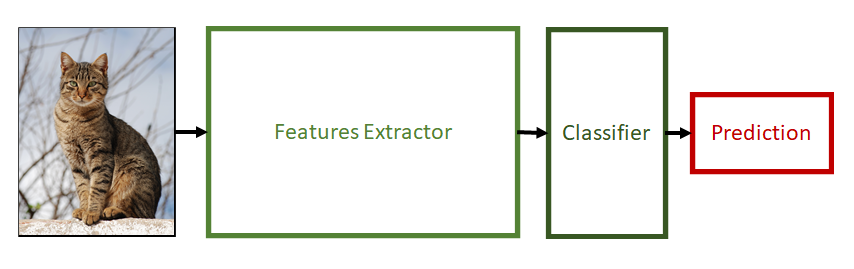

A transfer learning workflow for image classification includes the following steps:

1. **Take a pre-trained model**: choose a model that was trained on a large dataset to solve a similar problem. A common practice is to grab models from the literature such as: VGG, ResNet, MobileNet etc.
2. **Chop the classifier**: remove the old classifier.
3. **Add a new classifier**: adapt the architecture to solve the new task. 
4. **Use the convolutional block as Feature Extractor**: train **only** the new classifier on the new dataset and exclude the feature extractor from the back-propagation process (freezing).
5. **Fine-tuning**: a last optional step involves the **fine-tuning** of the new network. It consists in unfreezing parts of the pre-trained model and continue to training it on the new dataset in order to adapt the pretrained features to the new data. To avoid overfitting, we usually run this step only if the new dataset is **large**.

# Import Dependencies



In [ ]:
from __future__ import print_function
from __future__ import division

import random
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.utils as utils
import matplotlib.pyplot as plt
import numpy as np
import tarfile
import os

from timeit import default_timer as timer
from tqdm.auto import tqdm
from torchvision import datasets, models, transforms
from torchsummary import summary
from typing import Callable, Dict, List, Tuple, Union
from torch.optim import lr_scheduler
from torch.utils.tensorboard import SummaryWriter

# Reproducibility
Remember that deterministic operations tend to have slower performance than non-deterministic operations.

In [ ]:
def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use. 
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

fix_random(seed=7)

# Runtime Settings

Let's check that our  environment has the proper configuration.

In [ ]:
device = "cpu"
if torch.cuda.is_available:
  print('All good, a Gpu is available')
  device = torch.device("cuda:0")  
else:
  print('Please set GPU via Edit -> Notebook Settings.')

# Transfer Learning for Ants and Bees

As first example of this hands-on session, we want to build a neural network to distinguish between ants and bees. 


## Download the Ants and Bees Dataset
We can use the **Ants & Bees** dataset which is a very small subset of ImageNet. The dataset has  ~120 training images and ~75 validation images for each class.






Let's download the dataset and analyze it using the PyTorch functionalities.

In [ ]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip

In [ ]:
!unzip -qq hymenoptera_data.zip

We will use the [`torchvision.datasets.ImageFolder`](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) to manage our dataset.

In [ ]:
path_ds = 'hymenoptera_data'
path_ds_train = os.path.join(path_ds, 'train')
path_ds_val = os.path.join(path_ds, 'val')

mean_image_net = [0.485, 0.456, 0.406]
std_image_net = [0.229, 0.224, 0.225]

normalize = transforms.Normalize(mean_image_net, std_image_net)

size_image = 224
data_transforms = {'train': transforms.Compose([transforms.RandomResizedCrop(size_image),
                                                transforms.RandomHorizontalFlip(),
                                                transforms.ToTensor(),
                                                normalize]),
                   
                   'val': transforms.Compose([transforms.Resize(256),
                                              transforms.CenterCrop(size_image),
                                              transforms.ToTensor(),
                                              normalize])}

data_train = torchvision.datasets.ImageFolder(path_ds_train, data_transforms['train'])
data_val = torchvision.datasets.ImageFolder(path_ds_val, data_transforms['val'])

classes = data_train.classes
num_classes = len(classes)

print(f'Samples -> Train = {len(data_train)} - Val = {len(data_val)} '
      f'- Classes = {classes}')

Visualize some examples from the validation dataset.

In [ ]:
class NormalizeInverse(torchvision.transforms.Normalize):
    def __init__(self, mean: List[float], std: List[float]) -> None:
        """Reconstructs the images in the input domain by inverting 
        the normalization transformation.

        Args:
            mean: the mean used to normalize the images.
            std: the standard deviation used to normalize the images.
        """
        mean = torch.as_tensor(mean)
        std = torch.as_tensor(std)
        std_inv = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        super().__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        return super().__call__(tensor.clone())

def show_grid(dataset: torchvision.datasets.ImageFolder, 
              process: Callable = None) -> None:
    """Shows a grid with random images taken from the dataset.

    Args:
        dataset: the dataset containing the images.
        process: a function to apply on the images before showing them.        
    """
    fig = plt.figure(figsize=(15, 5))
    indices_random = np.random.randint(10, size=10, high=len(dataset))

    for count, idx in enumerate(indices_random):
        fig.add_subplot(2, 5, count + 1)
        title = dataset.classes[dataset[idx][1]]
        plt.title(title)
        image_processed = process(dataset[idx][0]) if process is not None else dataset[idx][0]
        plt.imshow(transforms.ToPILImage()(image_processed))
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

denormalize = NormalizeInverse(mean_image_net, std_image_net)
show_grid(data_val, process=denormalize)

Plot the distribution of data.

In [ ]:
def plot_histograms(dataset_train: torchvision.datasets.ImageFolder,
                    dataset_test: torchvision.datasets.ImageFolder,
                    title: str,
                    classes_as_ticks: bool = True) -> None:
    """Plot histograms with train and test or validation data distributions.

    Args:
        dataset_train: the train dataset.
        dataset_test: the test or validation dataset.
        title: the title of the plot.
        classes_as_ticks: if true the name of the classes are show in the x axis.
    """
    classes = len(dataset_train.classes)
    bins = np.linspace(0, classes, classes + 1, dtype=np.int)
    plt.title(title)
    plt.hist([dataset_train.targets, dataset_test.targets], bins=bins, 
             label=['ants', 'bees'])
    
    plt.legend(loc='upper right')
    
    if classes_as_ticks:
        x_ticks_names = ['Train', 'test']
        step = 1 / len(x_ticks_names)    
        x_ticks_pos = [(x * step) for x in np.arange(2 * len(x_ticks_names))][1::2]    
        
        plt.xticks(x_ticks_pos, x_ticks_names)
    plt.show()

plot_histograms(data_train, data_val, "Data Distribution")

Create the [data loaders](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for both the train and the validation dataset as well.

In [ ]:
num_workers = 4
size_batch = 4

loader_train = torch.utils.data.DataLoader(data_train, batch_size=size_batch, 
                                           shuffle=True, 
                                           pin_memory=True, 
                                           num_workers=num_workers)
loader_val = torch.utils.data.DataLoader(data_val, batch_size=size_batch, 
                                         shuffle=False,
                                         num_workers=num_workers)

## Train Functionalities


We are going to use the same functions defined in the previous hands-on session.

In [ ]:
# Accuracy
def get_correct_samples(scores: torch.Tensor, labels: torch.Tensor) -> int:
    """Gets the number of correctly classified examples.

    Args:
        scores: the scores predicted with the network.
        labels: the class labels.

    Returns: 
        the number of correct samples.
    """
    classes_predicted = torch.argmax(scores, 1)
    return (classes_predicted == labels).sum().item()

# Train one epoch
def train(writer: utils.tensorboard.writer.SummaryWriter,
          model: nn.Module,
          train_loader: utils.data.DataLoader,
          device: torch.device,          
          optimizer: torch.optim,
          criterion: Callable[[torch.Tensor, torch.Tensor], float],
          log_interval: int,
          epoch: int) -> Tuple[float, float]:
    """Trains a neural network for one epoch.

    Args:
        model: the model to train.
        train_loader: the data loader containing the training data.
        device: the device to use to train the model.        
        optimizer: the optimizer to use to train the model.
        criterion: the loss to optimize.
        log_interval: the log interval.
        epoch: the number of the current epoch.

    Returns:
        the cross entropy Loss value on the training data.
        the accuracy on the training data.
    """    
    correct = 0
    samples_train = 0
    loss_train = 0
    size_ds_train = len(train_loader.dataset)
    num_batches = len(train_loader)

    model.train()
    for idx_batch, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        scores = model(images)

        loss = criterion(scores, labels)
        loss_train += loss.item() * len(images)
        samples_train += len(images)        

        loss.backward()
        optimizer.step()
        correct += get_correct_samples(scores, labels)

        if log_interval > 0:
            if idx_batch % log_interval == 0:
                running_loss = loss_train / samples_train
                global_step = idx_batch + (epoch * num_batches) 
                writer.add_scalar('Metrics/Loss_Train_IT', running_loss, global_step)
                # Visualize images on tensorboard
                indices_random = torch.randperm(images.size(0))[:4]                
                writer.add_images('Samples/Train', denormalize(images[indices_random]), global_step)
                
    loss_train /= samples_train
    accuracy_training = 100. * correct / samples_train
    return loss_train, accuracy_training

# Validate one epoch
def validate(model: nn.Module,
             data_loader: utils.data.DataLoader,
             device: torch.device,
             criterion: Callable[[torch.Tensor, torch.Tensor], float]) -> Tuple[float, float]:
    """Evaluates the model.

    Args:
        model: the model to evalaute.
        data_loader: the data loader containing the validation or test data.
        device: the device to use to evaluate the model.
        criterion: the loss function.

    Returns:
        the loss value on the validation data.
        the accuracy on the validation data.
    """
    correct = 0
    samples_val = 0
    loss_val = 0.
    model = model.eval()
    with torch.no_grad():
        for idx_batch, (images, labels) in enumerate(data_loader):
            images, labels = images.to(device), labels.to(device)
            scores = model(images)

            loss = criterion(scores, labels)
            loss_val += loss.item() * len(images)
            samples_val += len(images)
            correct += get_correct_samples(scores, labels)

    loss_val /= samples_val
    accuracy = 100. * correct / samples_val
    return loss_val, accuracy

We have added a function to decay the learning rate using the [`StepLR`](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate) component of PyTorch. This function decays the learning rate by a factor of `gamma` every `step_size` epochs.

In [ ]:
def training_loop(writer: utils.tensorboard.writer.SummaryWriter,
                  num_epochs: int,
                  optimizer: torch.optim, 
                  lr_scheduler: torch.optim.lr_scheduler,
                  log_interval: int, 
                  model: nn.Module, 
                  loader_train: utils.data.DataLoader, 
                  loader_val: utils.data.DataLoader, 
                  verbose: bool=True) -> Dict:
    """Executes the training loop.
    
        Args:
            writer: the summary writer for tensorboard.
            num_epochs: the number of epochs.
            optimizer: the optimizer to use.
            lr_scheduler: the scheduler for the learning rate.
            log_interval: intervall to print on tensorboard.
            model: the mode to train.
            loader_train: the data loader containing the training data.
            loader_val: the data loader containing the validation data.
            verbose: if true print the value of loss.

        Returns:  
            A dictionary with the statistics computed during the train:
            the values for the train loss for each epoch.
            the values for the train accuracy for each epoch.
            the values for the validation accuracy for each epoch.
            the time of execution in seconds for the entire loop.
    """
    criterion = nn.CrossEntropyLoss()    
    loop_start = timer()

    losses_values = []
    train_acc_values = []
    val_acc_values = []
    for epoch in range(1, num_epochs + 1):
        time_start = timer()
        loss_train, accuracy_train = train(writer, model, loader_train, device, 
                                           optimizer, criterion, log_interval, 
                                           epoch)
        loss_val, accuracy_val = validate(model, loader_val, device, criterion)
        time_end = timer()

        losses_values.append(loss_train)
        train_acc_values.append(accuracy_train)
        val_acc_values.append(accuracy_val)
        
        lr = optimizer.param_groups[0]['lr']
        
        if verbose:            
            print(f'Epoch: {epoch} '
                  f' Lr: {lr:.8f} '
                  f' Loss: Train = [{loss_train:.4f}] - Val = [{loss_val:.4f}] '
                  f' Accuracy: Train = [{accuracy_train:.2f}%] - Val = [{accuracy_val:.2f}%] '
                  f' Time one epoch (s): {(time_end - time_start):.4f} ')
        
        # Plot to tensorboard        
        writer.add_scalar('Hyperparameters/Learning Rate', lr, epoch)
        writer.add_scalars('Metrics/Losses', {"Train": loss_train, "Val": loss_val}, epoch)
        writer.add_scalars('Metrics/Accuracy', {"Train": accuracy_train, "Val": accuracy_val}, epoch)
        writer.flush()
        
        # Increases the internal counter
        if lr_scheduler:            
            lr_scheduler.step()            
    
    loop_end = timer()
    time_loop = loop_end - loop_start
    if verbose:
        print(f'Time for {num_epochs} epochs (s): {(time_loop):.3f}') 
        
    return {'loss_values': losses_values,
            'train_acc_values': train_acc_values,
            'val_acc_values': val_acc_values,
            'time': time_loop}

## Why don't we train the network from scratch ?

To build our classifier we can use one of the off-the-shelf models provided in the [model zoo](https://pytorch.org/serve/model_zoo.html) of PyTorch. In this case, we will rely on a [ResNet18](https://pytorch.org/docs/stable/_modules/torchvision/models/resnet.html#resnet18). In this first example we will train the network from scratch. We have to set the parameter ```num_classes``` in the constructor of `models.resnet18` equal to the number of classes in our dataset (ie 2).

In [ ]:
net_from_scratch = models.resnet18(pretrained=False, num_classes=num_classes)
net_from_scratch.to(device)

summary(net_from_scratch,input_size=(3, size_image, size_image))

We can use similar hyperparameters to those used in the [paper](https://arxiv.org/pdf/1512.03385.pdf).


In [ ]:
def execute(name_train: str, network: nn.Module, starting_lr: float, 
            num_epochs: int, 
            data_loader_train: torch.utils.data.DataLoader,
            data_loader_val: torch.utils.data.DataLoader) -> None:
    """Executes the training loop.

    Args:
        name_train: the name for the log subfolder.
        network: the network to train.
        starting_lr: the staring learning rate.
        num_epochs: the number of epochs.
        data_loader_train: the data loader with training data.
        data_loader_val: the data loader with validation data.
    """
    # Visualization 
    log_interval = 20
    log_dir = os.path.join("logs", name_train)
    writer = torch.utils.tensorboard.writer.SummaryWriter(log_dir)
    
    # Optimization
    optimizer = optim.SGD(network.parameters(), lr=starting_lr, momentum=0.9, 
                          weight_decay=0.0001)

    # Learning Rate schedule 
    scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    statistics = training_loop(writer, num_epochs, optimizer, scheduler, 
                               log_interval, network, data_loader_train, 
                               data_loader_val)
    writer.close()

    best_epoch = np.argmax(statistics['val_acc_values']) + 1
    best_accuracy = statistics['val_acc_values'][best_epoch - 1]

    print(f'Best val accuracy: {best_accuracy:.2f} epoch: {best_epoch}.')

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir="logs"

In [ ]:
name_train = "resnet_from_scratch"
lr = 0.001
num_epochs = 20
execute(name_train, net_from_scratch, lr, num_epochs, loader_train, loader_val)

## Transfer Learning




Due to the too small size of our train dataset the solution learned from the network is not very accurate. This is the case in which transfer learning can help us. We can use the feature extractor trained on the ImageNet dataset as plug-and-play module and add a new classifier. In the picture below we recap the architecture of ResNet-18.

<img src = "https://forums.fast.ai/uploads/default/original/3X/f/9/f9a8eaaa866c2b783162fe65afdff67171e993fb.png" width = "400px" height="400px"> 

Let's take a look on the PyTorch [implemenation](https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py#L173) of [ResNet18](https://pytorch.org/hub/pytorch_vision_resnet/) in order to adapt the pre-trained architecture to the new task.






With the function below we cover the steps **1,2,3** of the workflow presented in the introduction.

In [ ]:
def get_model(pretrained: bool, num_classes: int) -> nn.Module:
    """Gets a image classifier based on ResNet18.

    Args:
        pretrained: if true initializes the network with ImageNet weights.
        num_classes: the number of classes.

    Returns: 
        The required network.
    """
    model = models.resnet18(pretrained=pretrained)
    # Here we override the old classifier
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    return model

To avoid to use the gradients with respect to some parameters of our model, we can set the attribute `requires_grad` to `False` as explained in the [autograd](https://pytorch.org/docs/stable/notes/autograd.html) page of PyTorch.

In [ ]:
def set_requires_grad_for_layer(layer: torch.nn.Module, train: bool) -> None:
    """Sets the attribute requires_grad to True or False for each parameter.
        
        Args:
            layer: the layer to freeze.
            train: if true train the layer.
    """
    for p in layer.parameters():
        p.requires_grad = train

In [ ]:
net_feat_ext = get_model(True, num_classes)
net_feat_ext.to(device)

set_requires_grad_for_layer(net_feat_ext.conv1, False)
set_requires_grad_for_layer(net_feat_ext.bn1, False)
set_requires_grad_for_layer(net_feat_ext.layer1, False)
set_requires_grad_for_layer(net_feat_ext.layer2, False)
set_requires_grad_for_layer(net_feat_ext.layer3, False)
set_requires_grad_for_layer(net_feat_ext.layer4, False)

summary(net_feat_ext, input_size=(3, size_image, size_image))

In [ ]:
name_train = "resnet_feat_ext"
execute(name_train, net_feat_ext, lr, num_epochs, loader_train, loader_val)



> **Good Practice**: *if you have limited amount of data, start from a pre-trained network.*



In [ ]:
#@title Show Predictions { run: "auto", display-mode: "form" }
index_sample = 6  #@param {type:"slider", min:0, max:152, step:1}
image, label =  data_val[index_sample]
batch_image = image.unsqueeze(0)

net_feat_ext.eval()
with torch.no_grad():
    output = net_feat_ext(batch_image.to(device))
    _, preds = torch.max(output, 1)

fig = plt.figure()
cax = plt.imshow(transforms.ToPILImage()(denormalize(image)))

title = f'Prediction: {classes[preds[0].item()]} - Label: {classes[label]}'
title_obj = plt.title(title) 
plt.setp(title_obj, color=("green" if preds[0]==label else "red")) 

plt.show()


## Fine Tuning the Network


Once the network has been trained on the new dataset, you can try to continue training for few epochs the whole model end-to-end on the new dataset using a lower learning rate. A common practice is to make the initial learning rate 10 times smaller than the one used to train the network from scratch.

> **Good Practice**: *use a smaller learning rate than the one use for the scratch training*.

> **Good Practice**: *fine-tune for few epochs*.

Check the trainable parameters for the froozen model.

In [ ]:
summary(net_feat_ext, input_size=(3, size_image, size_image))

In [ ]:
set_requires_grad_for_layer(net_feat_ext.conv1, True)
set_requires_grad_for_layer(net_feat_ext.bn1, True)
set_requires_grad_for_layer(net_feat_ext.layer1, True)
set_requires_grad_for_layer(net_feat_ext.layer2, True)
set_requires_grad_for_layer(net_feat_ext.layer3, True)
set_requires_grad_for_layer(net_feat_ext.layer4, True)

Check the trainable parameters.

In [ ]:
summary(net_feat_ext, input_size=(3, size_image, size_image))

Since the Ants and Bees dataset is small, it is not a good idea to fine-tune the network since we could easily orvefit it. 

In [ ]:
name_train = "resnet_fine_tuning"
lr_ft = lr * 0.1
num_epochs_ft = 10
execute(name_train, net_feat_ext, lr_ft, num_epochs_ft, loader_train, loader_val)

# Now it's your turn to try: Classify Food

Using the concepts just explained, try to develop an application to classify food images. You can use the [Food-101](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/) dataset. This dataset contains 101 food categories. In the following, you will find the code to download the dataset and extract only a subset of 11 classes.

You can proceed by following this workflow:
1. Create the [`Dataset`](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) using the `torchvision.datasets.ImageFolder` component.

2. Visualize the images and the distribution of the samples. Is the dataset balanced ?
3. Create the [`Dataloaders`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader).
4. Write a new function called `get_model_for_food` (you can take inspiration from the `get_model` function) in order to get a pre-trained [MobileNet V2.0](https://pytorch.org/hub/pytorch_vision_mobilenet_v2/) which can classify the 11 categories of food.
5. Train **only the classifier** of the new model and validate the new model: you can realize both by invoking the `execute` function as done above. What is the accuracy reached on the validation dataset ?

In [ ]:
!wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz

Extract only 11 categories.

In [ ]:
def gets_images_from_categories(path_file_tar: str, 
                                path_out: str,
                                categories: List[str]) -> int:
    """Extracts only images belonging to some categories.

    Args:
        path_file_tar: path to the tar file.
        path_out: path to the output folder.
        categories: the categories to use.

    Returns:
        the number of moved images.
    """
    num_images = 0
    tar = tarfile.open(path_file_tar, 'r')
    for member in tqdm(tar, leave=False):
        if member.name.find("jpg") > 0:
                category = member.name.split(os.sep)[-2]
                if category in categories:
                    tar.extract(member, path_out)
                    num_images += 1
        if member.name.find("txt") > 0:
            tar.extract(member, path_out)
    
    return num_images

categories = ['apple_pie', 'breakfast_burrito', 'chicken_curry', 'creme_brulee', 
              'falafel', 'frozen_yogurt', 'hot_and_sour_soup', 'macarons', 
              'pancakes', 'ramen', 'spaghetti_bolognese']
path_file_tar = "food-101.tar.gz"
gets_images_from_categories(path_file_tar, "", categories)

We need to split the image data into train and validation folders using the split files train.txt and test.txt.


In [ ]:
from collections import defaultdict
from shutil import copy

def arrange_images(path_split: str, path_source_dataset: str, 
                   path_dest_dataset:str, categories: List[str]) -> int:
    """Moves images from image folder to the destination folder according to the 
       split file.

    Args:
        path_split: the path to the text file containing the path of the images.
        path_source_dataset: the path to the images folder.
        path_dest_dataset: the path to the destination folder.

    Returns: 
        the number of moved images.
    """
    dict_cat_img = defaultdict(list)

    with open(path_split, 'r') as file_split:
        paths = [read.strip() for read in file_split.readlines()]
        for p in paths:
            category, file_name = p.split(os.sep)            
            if category in categories:
                dict_cat_img[category].append(file_name + '.jpg')

    num_images = 0
    categories = list(dict_cat_img.keys())
    for i in tqdm(range(len(categories)), leave=False):
        category = categories[i]
        path_dest_cat = os.path.join(path_dest_dataset, category)
        if not os.path.exists(path_dest_cat): os.makedirs(path_dest_cat)

        for image in dict_cat_img[category]:
            if os.path.isfile(os.path.join(path_source_dataset, category, image)):
                copy(os.path.join(path_source_dataset, category, image),
                     os.path.join(path_dest_dataset, category, image))
                num_images += 1
            
    return num_images

Get the train data.

In [ ]:
path_images_food = "food-101/images/"
path_split_train = "food-101/meta/train.txt"
path_images_food_train = "food-101/train"

In [ ]:
arrange_images(path_split_train, path_images_food, path_images_food_train, categories)

Get the validation data.

In [ ]:
path_split_val = "food-101/meta/test.txt"
path_images_food_val = "food-101/val"

In [ ]:
arrange_images(path_split_val, path_images_food, path_images_food_val, categories)

You can now use the variable `path_images_food_train` and `path_images_food_val`, to create the train and the validation datasets. As regard the data transformations you can use the same adopted for the ants and bees example.



In [ ]:
# Create the datasets.
# ==================================================================== #
#                         YOUR CODE STARTS HERE                        #
# ==================================================================== #
data_food_train = torchvision.datasets.ImageFolder(path_images_food_train, 
                                                   data_transforms['train'])
data_food_val = torchvision.datasets.ImageFolder(path_images_food_val, 
                                                 data_transforms['val'])

classes_food = data_food_train.classes
num_food_classes = len(classes_food)
print(f'Samples -> Train = {len(data_food_train)} - Val = {len(data_food_val)} \n'
      f'Classes = {num_food_classes}')
# ==================================================================== #
#                         YOUR CODE ENDS HERE                          #
# ==================================================================== #

In [ ]:
def plot_histograms(dataset_train: torchvision.datasets.ImageFolder,
                    dataset_test: torchvision.datasets.ImageFolder,
                    title: str,
                    classes_as_ticks: bool = True) -> None:
    """Plot histograms with train and test or validation data distributions.

    Args:
        dataset_train: the train dataset.
        dataset_test: the test or validation dataset.
        title: the title of the plot.
        classes_as_ticks: if true the name of the classes are show in the x axis.
    """
    classes = len(dataset_train.classes)
    bins = np.linspace(0, classes, classes + 1, dtype=np.int)
    plt.title(title)
    plt.hist([dataset_train.targets, dataset_test.targets], bins=bins, 
             label=['train', 'val'])
    
    plt.legend(loc='upper right')
    
    if classes_as_ticks:
        x_ticks_names = range(classes)
        step = 0.5
        x_ticks_pos = [(x * step) for x in np.arange(2 * len(x_ticks_names))][1::2]    
        print(x_ticks_pos)
        plt.xticks(x_ticks_pos, x_ticks_names)
    plt.show()

Before training, visualize some examples using the `show_grid` function and plot the distribution with `plot_histograms`.

In [ ]:
# Visualize the dataset.
# ==================================================================== #
#                         YOUR CODE STARTS HERE                        #
# ==================================================================== #
show_grid(data_food_val, process=denormalize)
plot_histograms(data_food_train, data_food_val, "Food-101", True)
# ==================================================================== #
#                         YOUR CODE ENDS HERE                          #
# ==================================================================== #

Create the dataloaders using the number of workers and the batch size provided in the cell below.

In [ ]:
# Create the loaders.
num_workers = 4
size_batch = 128
# ==================================================================== #
#                         YOUR CODE STARTS HERE                        #
# ==================================================================== #
loader_food_train = torch.utils.data.DataLoader(data_food_train, 
                                                batch_size=size_batch, 
                                                shuffle=True, 
                                                pin_memory=True, 
                                                num_workers=num_workers)

loader_food_val = torch.utils.data.DataLoader(data_food_val, 
                                              batch_size=size_batch, 
                                              shuffle=False,
                                              num_workers=num_workers)
# ==================================================================== #
#                         YOUR CODE ENDS HERE                          #
# ==================================================================== #

Write the function to get the required model. Remember that MobileNetV2.0 uses two attributes to store the feature extractor and the classifier called `features` and `classifier` respectively. Furthermore, the attribute 
`last_channel` stores the input activations for the classifier layer.



In [ ]:
# Write the get_model_for_food function.
def get_model_for_food(pretrained: bool, num_classes: int) -> nn.Module:
    """Gets a image classifier based on MobileNetV2.0.

    Args:
        pretrained: if true initializes the network with ImageNet weights.
        num_classes: the number of classes.

    Returns: 
        The required network.
    """
    # ==================================================================== #
    #                         YOUR CODE STARTS HERE                        #
    # ==================================================================== #
    model = models.mobilenet_v2(pretrained=pretrained)
    classifier = nn.Sequential(nn.Dropout(0.2), 
                               nn.Linear(model.last_channel, num_classes))
    model.classifier = classifier

    return model
    # ==================================================================== #
    #                         YOUR CODE ENDS HERE                          #
    # ==================================================================== #

net_food = get_model_for_food(True, num_food_classes)
net_food.to(device)

Use `set_requires_grad_for_layer` to freeze the feature extractor of MobileNetV2.0. Is the number of trainable parameters correct ?

In [ ]:
# ==================================================================== #
#                         YOUR CODE STARTS HERE                        #
# ==================================================================== #
set_requires_grad_for_layer(net_food.features, False)
summary(net_food, input_size=(3, size_image, size_image))
# ==================================================================== #
#                         YOUR CODE ENDS HERE                          #
# ==================================================================== #

Finally, train and validate the model running the `execute` function. It should take about a minute per epoch.

In [ ]:
# Run the execute function with the new model.
name_train = "mobile_net_feat_ext"
lr_food = 0.001
num_epochs_food = 8
# ==================================================================== #
#                         YOUR CODE STARTS HERE                        #
# ==================================================================== #
execute(name_train, net_food, lr_food, num_epochs_food, loader_food_train, 
        loader_food_val)
# ==================================================================== #
#                         YOUR CODE ENDS HERE                          #
# ==================================================================== #

Try to classify an image from the web.

In [ ]:
import requests
from PIL import Image

image_url = 'https://supervalu.ie/thumbnail/720x400/var/files/real-food/recipes/Uploaded-2020/spaghetti-bolognese-recipe.jpg?fill=1'
response = requests.get(image_url, stream = True)

# Open and show the image
image = Image.open(response.raw)
plt.imshow(image)
plt.axis("off")
plt.show()

# Get the prediction
image = data_transforms["val"](image)
image = image.unsqueeze(0).to(device)

net_food.eval()
with torch.no_grad():
    net_output = net_food(image)
    pred = torch.argmax(net_output, 1)

food_categories = data_food_train.classes
print(f'The picture contains: {food_categories[pred.item()]}')

# Try This at Home

1. Instead of using only 11 categories, try to use the whole dataset to run the steps above.
2. Now the size of dataset is much larger than the one used for this hands-on session, thus you can try to fine-tune the network and see if it can help to reach better accuracy in validation.
3. Change the optimizer in the `execute` function and the learning rate schedule as well.
4. Modify the `training_loop` function in order to get the model with the best accuracy on the validation data set and test it on new images of food.